# LSTM Notebook


In [1]:
import os
import json
import optuna
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\aryan\Desktop\XAI\XAI_Models\time_series\dataset4\train.csv")

             Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
count   9800.000000            9800        9800        9800            9800   
unique          NaN            4922        1230        1326               4   
top             NaN  CA-2018-100111  05/09/2017  26/09/2018  Standard Class   
freq            NaN              14          38          34            5859   
mean    4900.500000             NaN         NaN         NaN             NaN   
std     2829.160653             NaN         NaN         NaN             NaN   
min        1.000000             NaN         NaN         NaN             NaN   
25%     2450.750000             NaN         NaN         NaN             NaN   
50%     4900.500000             NaN         NaN         NaN             NaN   
75%     7350.250000             NaN         NaN         NaN             NaN   
max     9800.000000             NaN         NaN         NaN             NaN   

       Customer ID  Customer Name   Segment        

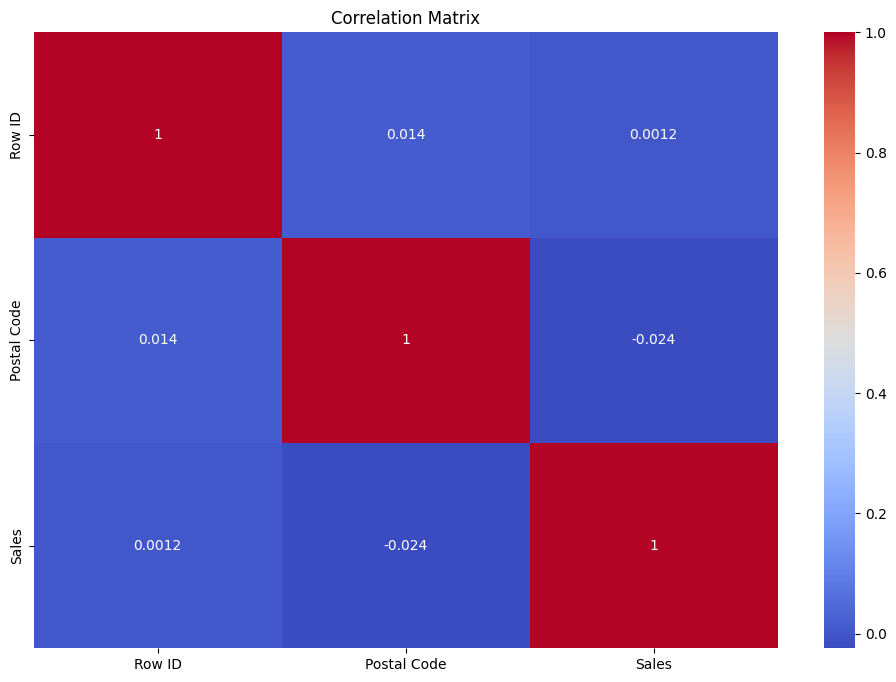

In [3]:
# Display basic statistics
print(df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

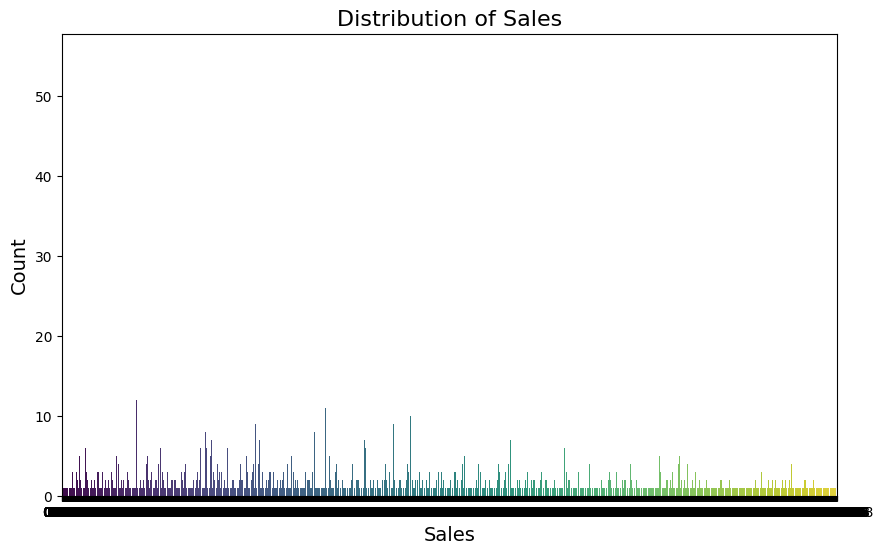

In [4]:
# Distribution of glass types
plt.figure(figsize=(10, 6))
sns.countplot(x='Sales', data=df, palette='viridis')
plt.title('Distribution of Sales', fontsize=16)
plt.xlabel('Sales', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


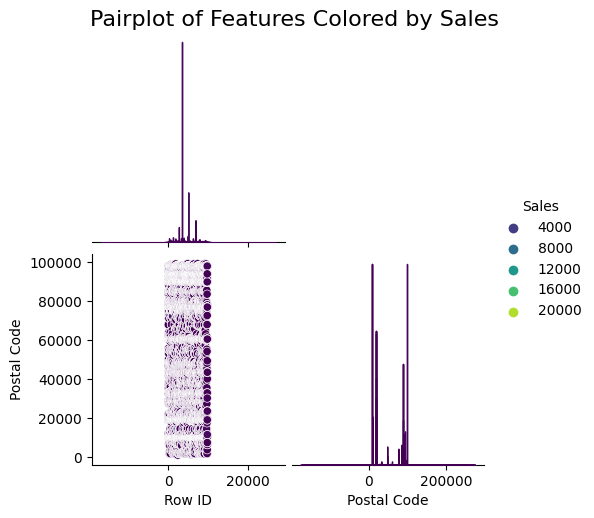

In [5]:
# Pairplot
sns.pairplot(df, hue='Sales', palette='viridis', corner=True)
plt.suptitle('Pairplot of Features Colored by Sales', y=1.02, fontsize=16)
plt.show()

In [6]:
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d/%m/%Y")
df = df.groupby("Order Date")["Sales"].sum().reset_index()
df = df.sort_values("Order Date")
df

,Order Date,Sales
0,2015-01-03,16.4480
1,2015-01-04,288.0600
2,2015-01-05,19.5360
3,2015-01-06,4407.1000
4,2015-01-07,87.1580
...,...,...
1225,2018-12-26,814.5940
1226,2018-12-27,177.6360
1227,2018-12-28,1657.3508
1228,2018-12-29,2915.5340


In [7]:
# Scaling data
scaler = MinMaxScaler()
df["Sales"] = scaler.fit_transform(df[["Sales"]])


In [8]:
# Convert data into sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(df["Sales"].values, seq_length)

In [9]:
# Split data
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]


In [10]:
# Define JSON file for storing best parameters
model_name = "LSTM"
json_file = f"{model_name}.json"

In [11]:
# Objective function for Optuna
def objective(trial):
    model = Sequential([
        LSTM(units=trial.suggest_int("units", 10, 100), return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(trial.suggest_uniform("dropout", 0.1, 0.5)),
        LSTM(units=trial.suggest_int("units_2", 10, 100)),
        Dropout(trial.suggest_uniform("dropout_2", 0.1, 0.5)),
        Dense(1)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=trial.suggest_loguniform("learning_rate", 0.0001, 0.01)),
                  loss="mse")
    model.fit(X_train, y_train, epochs=10, batch_size=trial.suggest_int("batch_size", 8, 64), verbose=0)
    
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)


In [12]:

# Check if hyperparameters exist and are valid
if os.path.exists(json_file):
    with open(json_file, "r") as file:
        best_params = json.load(file)
    
    # If JSON file contains invalid hyperparameters, re-run optimization
    if not all(key in best_params for key in ["units", "dropout", "units_2", "dropout_2", "learning_rate", "batch_size"]):
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=50)
        best_params = study.best_params
        with open(json_file, "w") as file:
            json.dump(best_params, file)
else:
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50)
    best_params = study.best_params
    with open(json_file, "w") as file:
        json.dump(best_params, file)

print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'units': 49, 'dropout': 0.24297887448492025, 'units_2': 71, 'dropout_2': 0.15274308686736363, 'learning_rate': 0.003577018845748504, 'batch_size': 46}


In [13]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
class LSTMPredictor(BaseEstimator, RegressorMixin):
    def __init__(self, units=50, dropout=0.2, units_2=50, dropout_2=0.2, learning_rate=0.001, batch_size=32, epochs=50):
        self.units = units
        self.dropout = dropout
        self.units_2 = units_2
        self.dropout_2 = dropout_2
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None
    
    def build_model(self, input_shape):
        model = Sequential([
            LSTM(units=self.units, return_sequences=True, input_shape=input_shape),
            Dropout(self.dropout),
            LSTM(units=self.units_2),
            Dropout(self.dropout_2),
            Dense(1)
        ])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate), loss="mse")
        return model
    
    def fit(self, X, y):
        X = X.reshape((X.shape[0], X.shape[1], 1))  # Ensure correct shape
        self.model = self.build_model((X.shape[1], 1))
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
        return self
    
    def predict(self, X):
        X = X.reshape((X.shape[0], X.shape[1], 1))
        return self.model.predict(X).flatten()

# Initialize LSTM model with best hyperparameters
lstm_regressor = LSTMPredictor(
    units=best_params["units"], 
    dropout=best_params["dropout"],
    units_2=best_params["units_2"],
    dropout_2=best_params["dropout_2"],
    learning_rate=best_params["learning_rate"],
    batch_size=best_params["batch_size"],
    epochs=50
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', scaler),
    ('regressor', lstm_regressor)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

print("LSTM model trained successfully!")


Epoch 1/50
22/22 [==============================] - 8s 12ms/step - loss: 0.0067
Epoch 2/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0065
Epoch 3/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 4/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0064
Epoch 5/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0063
Epoch 6/50
22/22 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 7/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0063
Epoch 8/50
22/22 [==============================] - 0s 10ms/step - loss: 0.0064
Epoch 9/50
22/22 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 10/50
22/22 [==============================] - 0s 6ms/step - loss: 0.0063
Epoch 11/50
22/22 [==============================] - 0s 7ms/step - loss: 0.0064
Epoch 12/50
22/22 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 13/50
22/22 [======================

In [19]:
from sklearn.model_selection import cross_val_score

# Define a function to create the pipeline
def create_pipeline():
	lstm_regressor = LSTMPredictor(
		units=best_params["units"], 
		dropout=best_params["dropout"],
		units_2=best_params["units_2"],
		dropout_2=best_params["dropout_2"],
		learning_rate=best_params["learning_rate"],
		batch_size=best_params["batch_size"],
		epochs=50
	)
	pipeline = Pipeline(steps=[
		('preprocessor', scaler),
		('regressor', lstm_regressor)
	])
	return pipeline

# Perform cross-validation on the training data
pipeline = create_pipeline()
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Epoch 1/50
17/17 [==============================] - 3s 10ms/step - loss: 0.0068
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0056
Epoch 3/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 4/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 5/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 6/50
17/17 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 7/50
17/17 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 8/50
17/17 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 9/50
17/17 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 10/50
17/17 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 11/50
17/17 [==============================] - 0s 7ms/step - loss: 0.0057
Epoch 12/50
17/17 [==============================] - 0s 10ms/step - loss: 0.0057
Epoch 13/50
17/17 [============================

In [22]:
# Ensure the pipeline is fitted before making predictions
if pipeline.named_steps['regressor'].model is None:
	pipeline.named_steps['regressor'].fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

Epoch 1/50
22/22 [==============================] - 3s 10ms/step - loss: 0.0069
Epoch 2/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0063
Epoch 3/50
22/22 [==============================] - 0s 17ms/step - loss: 0.0063
Epoch 4/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0065
Epoch 5/50
22/22 [==============================] - 0s 9ms/step - loss: 0.0064
Epoch 6/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0063
Epoch 7/50
22/22 [==============================] - 0s 12ms/step - loss: 0.0064
Epoch 8/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0064
Epoch 9/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0063
Epoch 10/50
22/22 [==============================] - 0s 17ms/step - loss: 0.0064
Epoch 11/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0063
Epoch 12/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0065
Epoch 13/50
22/22 [===================

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate regression metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R2 Score: 0.025242844994045055
Mean Absolute Error (MAE): 0.06251278995262714
Mean Squared Error (MSE): 0.007403108458033
Root Mean Squared Error (RMSE): 0.08604131831877636


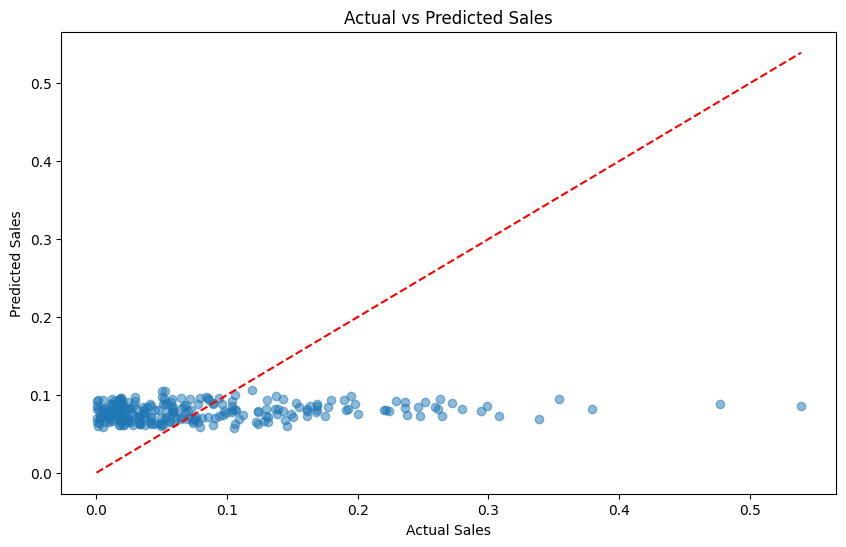

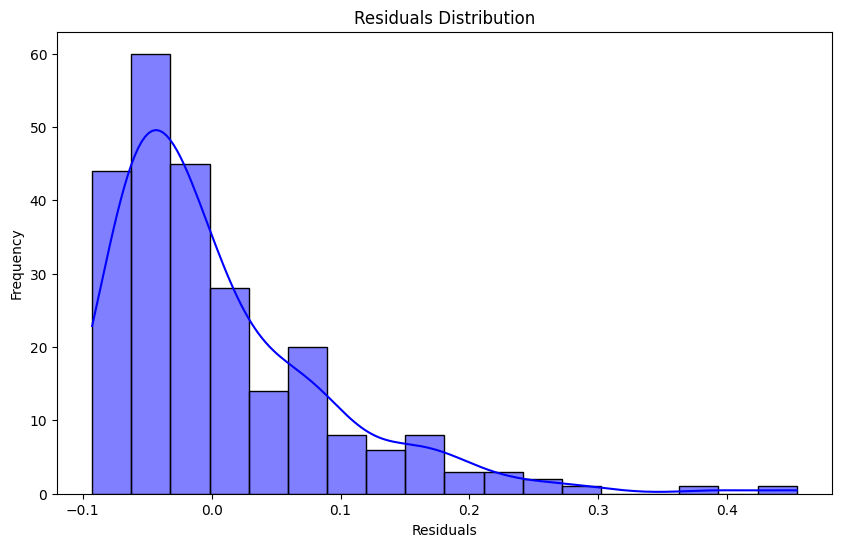

In [24]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [34]:
%pip install shap
import shap

# Initialize SHAP Explainer with a subset of the training data
subset_size = 100  # Adjust the subset size as needed
X_train_subset = X_train[:subset_size]

explainer = shap.KernelExplainer(lambda x: pipeline.named_steps['regressor'].model.predict(x.reshape((x.shape[0], x.shape[1], 1))), X_train_subset)

# Generate SHAP values for a subset of the test data
X_test_subset = X_test[:subset_size]
shap_values = explainer.shap_values(X_test_subset)


Note: you may need to restart the kernel to use updated packages.
4/4 [==============================] - 0s 10ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

3194/3194 [==============================] - 9s 3ms/step


c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


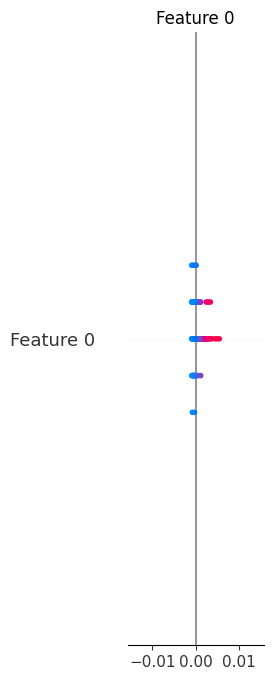

In [36]:
shap.summary_plot(shap_values, X_test_subset.reshape(X_test_subset.shape[0], X_test_subset.shape[1]))


In [43]:
# Store metrics
metrics_data = []
# Append results
metrics_data.append({
    "Model": model_name,
    "R2_Score": r2,
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "Root Mean Squared Error": rmse
})

# Save metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv("lstm_metrics.csv", index=False)

In [44]:
import joblib

# Assuming the model is trained in your .ipynb session and available in memory
# Replace 'model' with the actual variable holding your trained model
joblib.dump(lstm_regressor, 'lstm.pkl')

print("Model saved successfully as 'lstm.pkl'")


Model saved successfully as 'lstm.pkl'
